# Performance of LLMs on the GPQA benchmark
This notebook examines the performance of various large language models (LLMs) on the GPQA dataset.

Hugging Face dataset: https://huggingface.co/datasets/Idavidrein/gpqa
* We use the `gpqa_main` subset filtering question by `df['Domain'] == 'Biology'`

Paper: https://arxiv.org/abs/2311.12022

## Setup

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'

model_dir_names = [
    'gpt-4o',
    'gemini-1.5-pro',
    'claude-3.5-sonnet',
    'llama-3.1-405b'
]

models_data_file = '../../../models/models_data.tsv'

large_scale_models_file = '../../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

Then, we merge the Epoch data with manually collected model metadata.

In [3]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

In [4]:
models_df = pd.read_csv(models_data_file, sep='\t')

# models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')

## Load results from Inspect
Load the contents of a log directory into a dataframe and compute estimated cost per run.

In [5]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

def process_log_files(log_files_dir, model_dir_names):
    results = []
    
    for model_dir in model_dir_names:
        log_path = os.path.join(log_files_dir, model_dir)
        for filename in os.listdir(log_path):
            if filename.endswith('.json'):
                file_path = os.path.join(log_path, filename)
                with open(file_path, 'r') as f:
                    log = json.load(f)
                
                if log['status'] == "success":
                    model_name = log['eval']['model']
                    
                    # Extract data from logs
                    accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                    task_name = log['eval']['task']
                    dataset_samples = log['eval']['dataset']['samples']
                    completed_samples = log['results']['completed_samples']
                    input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                    output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                    start_time = log['stats']['started_at']
                    end_time = log['stats']['completed_at']
                    
                    # Calculate cost for this run
                    run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                    
                    results.append({
                        'inspect_model_name': model_name,
                        'accuracy': accuracy,
                        'stderr': stderr,
                        'total_tokens': token_usage,
                        'input_tokens': input_tokens,
                        'output_tokens': output_tokens,
                        'task': task_name,
                        'dataset_samples': dataset_samples,
                        'completed_samples': completed_samples,
                        'run_id': log['eval']['run_id'],
                        'created': log['eval']['created'],
                        'start_time': start_time,
                        'end_time': end_time,
                        'filename': filename,
                        'estimated_cost': run_cost
                    })
        
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir, model_dir_names)

In [6]:
gpqa_df = results_df.merge(models_df, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
gpqa_df.to_csv(results_df_path, index=False)
gpqa_df.head()

,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,filename,estimated_cost,epoch_model_name,biggest_in_class,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated
0,openai/gpt-4o,0.628205,0.055075,62438,25030,37408,benchmarks/gpqa,78,78,QJnj7nYrVsctmQ4n7FhmX7,...,2024-09-25T15-34-10-04-00_benchmarks-gpqa_VWBk...,0.69,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
1,openai/gpt-4o,0.653846,0.054216,62611,25029,37582,benchmarks/gpqa,78,78,ZcMY3ihcbAu5p2aBaz7G8y,...,2024-09-25T15-36-37-04-00_benchmarks-gpqa_VoPc...,0.69,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
2,openai/gpt-4o,0.653846,0.054216,60765,25030,35735,benchmarks/gpqa,78,78,K99ue2gxHGFapd7vH6q8ey,...,2024-09-25T15-29-27-04-00_benchmarks-gpqa_Yq5Q...,0.66,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
3,openai/gpt-4o,0.692308,0.052597,61711,25029,36682,benchmarks/gpqa,78,78,CTbuahCVdXig3wzHDzaB5U,...,2024-09-25T15-31-44-04-00_benchmarks-gpqa_d3Qd...,0.68,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
4,openai/gpt-4o,0.679487,0.053182,61928,25027,36901,benchmarks/gpqa,78,78,GGbHaNWmDCwabLEQsmZojP,...,2024-09-25T15-25-39-04-00_benchmarks-gpqa_EWSG...,0.68,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03


## Cost analysis

In [7]:
cost_summary = gpqa_df.groupby('inspect_model_name').agg({
    'estimated_cost': ['count', 'sum', 'mean'],
    'input_tokens': 'sum',
    'output_tokens': 'sum'
}).reset_index()
cost_summary.head()

cost_summary.columns = [
    'Model', 'Total Runs', 'Estimated Total Cost', 'Estimated Average Cost per Run',
    'Total Input Tokens', 'Total Output Tokens'
]

cost_summary = cost_summary[[
    'Model', 'Total Runs', 'Total Input Tokens', 'Total Output Tokens',
    'Estimated Total Cost', 'Estimated Average Cost per Run'
]]

print("Cost Analysis for GPQA Benchmark:")
print(cost_summary.to_string(index=False))

# Calculate and display the grand total cost
grand_total_cost = cost_summary['Estimated Total Cost'].sum()
print(f"\nEstimated Total Cost for all models: ${grand_total_cost:.2f}")

Cost Analysis for GPQA Benchmark:
                                                 Model  Total Runs  Total Input Tokens  Total Output Tokens  Estimated Total Cost  Estimated Average Cost per Run
                  anthropic/claude-3-5-sonnet-20240620          10              288310               318319                  5.63                           0.563
                                 google/gemini-1.5-pro          10              242181               258680                  3.58                           0.358
                                         openai/gpt-4o          10              250286               373197                  6.86                           0.686
together/meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo          10              276725               398736                  3.37                           0.337

Estimated Total Cost for all models: $19.44


<Figure size 1200x800 with 0 Axes>

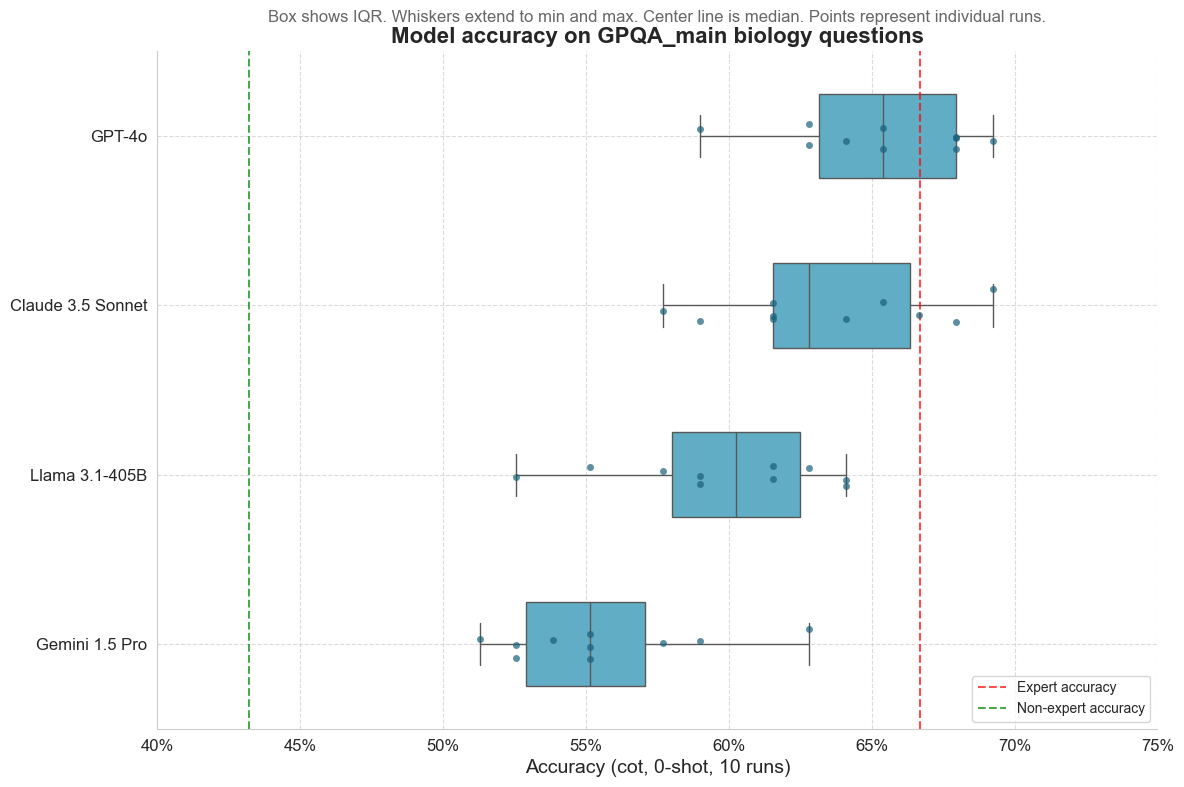

In [9]:
# Set up the plot style
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
box_color = '#4FB6D6'
point_color = '#1A5F7A'

# Create box plot
sns.boxplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
            ax=ax, color=box_color, width=0.5, 
            showfliers=False, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Add jittered points
sns.stripplot(x='accuracy', y='epoch_model_name', data=gpqa_df, 
              ax=ax, color=point_color, alpha=0.7, size=5, 
              jitter=True, order=gpqa_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Customize the plot
ax.set_xlabel('Accuracy (cot, 0-shot, 10 runs)', fontsize=14)
ax.set_ylabel('')
ax.set_xlim(0.4, 0.75)
ax.set_xticks(np.arange(0.4, 0.76, 0.05))
ax.set_xticklabels([f'{x:.0%}' for x in np.arange(0.4, 0.76, 0.05)])

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add reference lines
ax.axvline(x=0.667, color='red', linestyle='--', alpha=0.7, label='Expert accuracy')
ax.axvline(x=0.432, color='green', linestyle='--', alpha=0.7, label='Non-expert accuracy')
# ax.axvline(x=0.25, color='blue', linestyle='--', alpha=0.7, label='Random guess')

# Add legend
ax.legend(fontsize=10, loc='lower right')

# Add title
plt.title('Model accuracy on GPQA_main biology questions', fontsize=16, fontweight='bold')

# Add subtitle
plt.text(0.5, 1.05, 'Box shows IQR. Whiskers extend to min and max. Center line is median. Points represent individual runs.',
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.savefig('gpqa_cot_accuracy_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()